# Synthetic VNF Data

Gen synth data and fit multiple models agains it

In [239]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(font_scale=3, style="white")

In [240]:
class FixedModel(BaseEstimator):
    """
    sklearn model of the fixed model, 
    always allocating/predicting a fixed, pre-defined amount of resources.
    For use in sklearn functions like k-fold CV
    """
    def __init__(self, fixed_value):
        self.fixed_value = fixed_value
        
    def fit(self, X, y):
        """There's nothing to fit here"""
        return self
    
    def predict(self, X):
        """Always 'predict' the specified fixed value"""
        n_samples = X.shape[0]
        return [self.fixed_value for _ in range(n_samples)]

In [241]:
# define column names
cpu_col = 'Resource req. [e.g., CPU]'
thr_col = 'Traffic load [e.g., Mbit/s]'

In [242]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark():
    """Generate synthetic benchmark results for CPU time 0-100%"""
    cpu_list = np.arange(0.1, 1, .01)
    data = []
    for cpu in cpu_list:
        data.append([cpu, gen_benchmark(cpu, coeff2=100)])
    return pd.DataFrame(data, columns=[cpu_col, thr_col])

# inverse function to calculate cpu given a throughput
def inverse(thru, coeff2=1):
    return (1/coeff2) * (2**thru - 1)

In [243]:
# prepare data
df = synthetic_benchmark()
X = df[[thr_col]]
y = df[cpu_col]

In [244]:
def cross_validation_rmse(model, X, y, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/synth_data/{name}.joblib')
    return rmse 

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots(figsize = (8, 6))
    plt.barh(x, rmse_mean, color='grey', xerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('RMSE')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

CV RMSE of LinearRegression: 0.12121162713679334 (+/-0.0834142420571489)
CV RMSE of Ridge: 0.1157083036553567 (+/-0.07204672163128789)
CV RMSE of SVR: 0.15772899390054107 (+/-0.08774146778153001)
CV RMSE of RandomForestRegressor: 0.079016930017029 (+/-0.02892004867091995)
CV RMSE of GradientBoostingRegressor: 0.07805364007331642 (+/-0.025433426403506574)
CV RMSE of MLPRegressor: 0.1884970322400931 (+/-0.19317890469508217)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


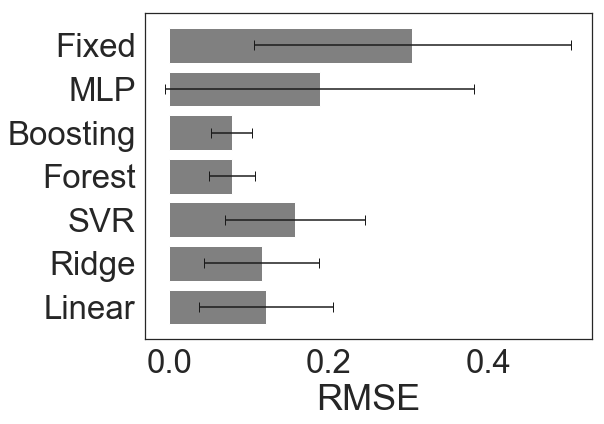

In [245]:
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor(max_iter=1500), 
          FixedModel(fixed_value=0.8)]
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP', 'Fixed']
rmse = [cross_validation_rmse(model, X, y) for model in models]

barplot_rmse(rmse, labels, 'synth_default')

CV RMSE of LinearRegression: 0.12121162713679334 (+/-0.0834142420571489)
CV RMSE of Ridge: 0.09668457215749979 (+/-0.060822156542014665)
CV RMSE of SVR: 0.10148672105555254 (+/-0.04273273250016648)
CV RMSE of RandomForestRegressor: 0.07883837751219168 (+/-0.026953441506102894)
CV RMSE of GradientBoostingRegressor: 0.07805364007331642 (+/-0.025433426403506574)
CV RMSE of MLPRegressor: 0.1386704339625999 (+/-0.05389148824940066)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


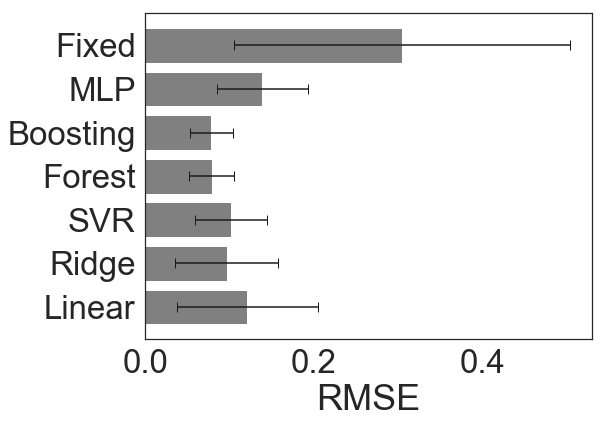

In [246]:
# scale the data and do again
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
os.makedirs(f'ml_models/synth_data', exist_ok=True)
joblib.dump(scaler, f'ml_models/synth_data/scaler.joblib')

rmse = [cross_validation_rmse(model, X_scaled, y) for model in models]
barplot_rmse(rmse, labels, 'synth_scaled')

In [247]:
def tune_hyperparams(model, X, y, params):
    """Do grid search CV for hyperparam tuning and return CV RMSE"""
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X, y)   
    return grid_search.best_estimator_

CV RMSE of LinearRegression: 0.12121162713679334 (+/-0.0834142420571489)
CV RMSE of Ridge: 0.09668457215749979 (+/-0.060822156542014665)
CV RMSE of SVR: 0.005448995192915848 (+/-0.005411929454877605)
CV RMSE of RandomForestRegressor: 0.07856988066678042 (+/-0.026776989848397992)
CV RMSE of GradientBoostingRegressor: 0.07755613024304038 (+/-0.025150165128635854)
CV RMSE of MLPRegressor: 0.09011693060882102 (+/-0.04934555264115149)
CV RMSE of FixedModel: 0.30476112171679437 (+/-0.19909124881970067)


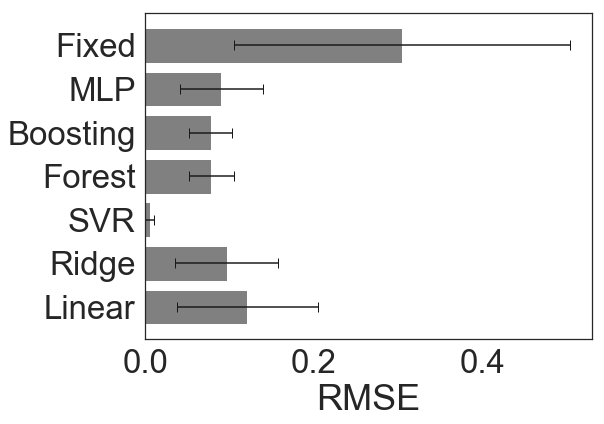

In [248]:
# hyperparam tuning
params_ridge = {'alpha': [0.1, 1, 10]}
params_svr = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100], 
              'epsilon': [0.001, 0.01, 0.1]}
params_forest = {'n_estimators': [10, 100, 200]}
params_boosting = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [10, 100, 200]}
params_mlp = {'hidden_layer_sizes': [(64,), (128,), (256)], 'alpha': [0.001, 0.0001, 0.00001],
              'learning_rate_init': [0.01, 0.001, 0.0001]}

params = [{}, params_ridge, params_svr, params_forest, params_boosting, params_mlp, {}]
models_tuned = [tune_hyperparams(models[i], X_scaled, y, params[i]) for i in range(len(models))]
rmse_tuned = [cross_validation_rmse(model, X_scaled, y, save_model=True) for model in models_tuned]

barplot_rmse(rmse_tuned, labels, 'synth_tuned')

In [249]:
# plot
sns.set(font_scale=1, style="white")

def plot_predictions(models, labels, X, y):
    assert len(models) == len(labels)
    
    fig, ax = plt.subplots()
    plt.plot(X[thr_col], y, label='True', color='black', linewidth=2)
    
    for i in range(len(models)):
        models[i].fit(X, y)
        plt.plot(X[thr_col], models[i].predict(X), label=labels[i])

    plt.xlabel(thr_col)
    plt.ylabel(cpu_col)
    plt.ylim(0, 1)
    plt.legend()

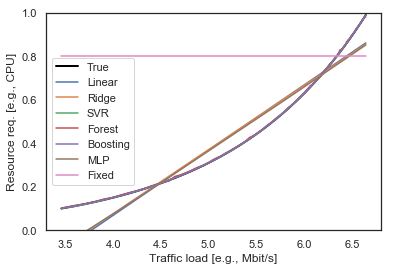

In [250]:
plot_predictions(models_tuned, labels, X, y)